In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

plt.rcParams['axes.axisbelow'] = True   # Set axes and grid elements to be below the figure

## Heston Stochastic Volatility Model

![Heston Stochastic Volatility Model](heston_stochastic_volatility.png)

In [2]:
# SET PARAMETERS ======================================================================================================
N_SIMS = 20000                           # FIXME: number of simulations
N_STEPS = 200                            # FIXME: number of steps (excluding t = 0)
T = 1                                    # FIXME: time horizon
RHO = -0.8                               # FIXME: correlation between price process and variance process

# Parameters for the price process
S0 = 1                                   # FIXME: initial price
MU = 0.02                                # FIXME: drift

# Parameters for the variance process
V0 = 0.08                                # FIXME: initial volatility
THETA = 0.08                             # FIXME: mean reversion level
KAPPA = 1                                # FIXME: mean reversion rate
SIGMA = 0.5                              # FIXME: volatility of volatility

dt = T / N_STEPS                         # time step size
t_steps = np.linspace(0, T, N_STEPS + 1) # time steps

# SIMULATION =========================================================================================================

Z1 = np.random.randn(N_STEPS, N_SIMS)
Z2 = RHO * Z1 + np.sqrt(1 - RHO ** 2) * np.random.randn(N_STEPS, N_SIMS)

# Initialize the price and volatility processes
V = np.vstack([np.full(N_SIMS, V0), np.zeros((N_STEPS, N_SIMS))])

# Volatility process -------------------------------------------------------------------------------------------------
# Euler-Maruyama method ----------------------------------------------------------------------------
# for i in range(N_STEPS):
#     V[i + 1] = V[i] + KAPPA * (THETA - V[i]) * dt + SIGMA * np.sqrt(V[i]) * np.sqrt(dt) * Z2[i]
#     V[i + 1] = np.maximum(V[i + 1], 0)

# Gaussian Approximation ---------------------------------------------------------------------------
a = SIGMA**2 / KAPPA * (np.exp(-KAPPA * dt) - np.exp(-2 * KAPPA * dt))
b = THETA * SIGMA**2 / (2 * KAPPA) * (1 - np.exp(-KAPPA * dt))**2
for i in range(N_STEPS):
    V[i + 1] = THETA * (1 - np.exp(-KAPPA * dt)) + V[i] * np.exp(-KAPPA * dt) + np.sqrt(a * V[i] + b) * Z2[i]
    V[i + 1] = np.maximum(V[i + 1], 0)

# Exact --------------------------------------------------------------------------------------------
# d = 4 * KAPPA * THETA / SIGMA**2
# k = SIGMA**2 * (1 - np.exp(-KAPPA * dt)) / (4 * KAPPA)
# for i in range(N_STEPS):
#     lam = 4 * KAPPA * V[i] / (SIGMA**2 * (np.exp(KAPPA * dt) - 1))
#     V[i + 1] = np.random.noncentral_chisquare(df = d, nonc = lam, size = (1, N_SIMS)) * k

# Price process ------------------------------------------------------------------------------------------------------    
# ABM Process --------------------------------------------------------------------------------------
S = (MU - 0.5 * V[:-1]) * dt + np.sqrt(V[:-1] * dt) * Z1
S = np.vstack([np.zeros(N_SIMS), S.cumsum(axis = 0)])
S += S0

# GBM Process --------------------------------------------------------------------------------------
# S = (MU - 0.5 * V[:-1]) * dt + np.sqrt(V[:-1] * dt) * Z1
# S = np.vstack([np.zeros(N_SIMS), S.cumsum(axis = 0)])
# S = S0 * np.exp(S)

# Statistics =========================================================================================================
exact_mean = (S0 + (MU - 0.5 * THETA) * t_steps + (THETA - V0) * (1 - np.exp(-KAPPA * t_steps)) / (2 * KAPPA)) # For ABM


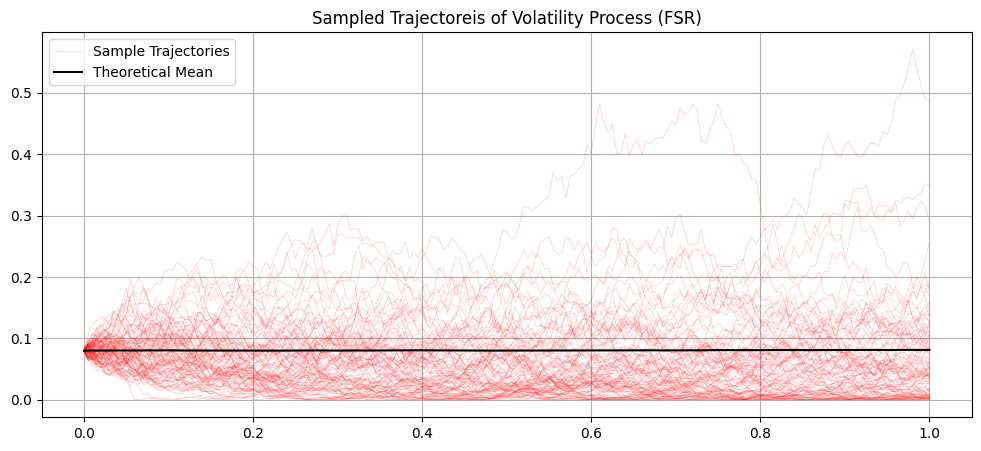

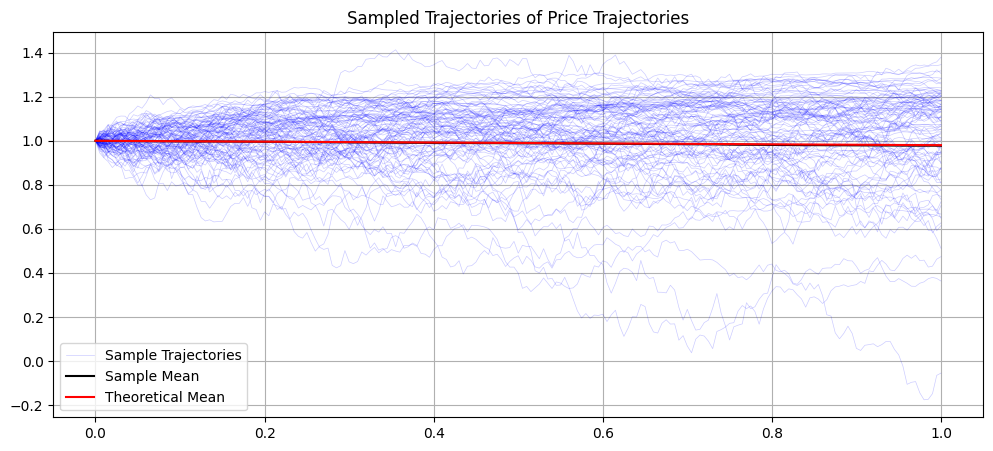

NameError: name 'xs' is not defined

<Figure size 1200x500 with 0 Axes>

In [3]:
# Trajectories & Slices
# Volatility Trajectories ====================================================================
plt.figure(figsize = (12, 5), clear = True)

plt.title("Sampled Trajectoreis of Volatility Process (FSR)")
plt.plot(t_steps, V[:,:100], color = "red", alpha = 0.2, lw = 0.5, label = "Sample Trajectories")
plt.plot(t_steps, V.mean(axis = 1), color = "black", label = "Theoretical Mean")

handles, labels = plt.gca().get_legend_handles_labels() # This gets the handles and labels of the current axes
by_label = dict(zip(labels, handles)) # dict(zip(keys, values)) is a way to create a dictionary from two lists
plt.legend(by_label.values(), by_label.keys())
plt.grid()
plt.show()

# Price Trajectoris ==========================================================================
plt.figure(figsize = (12, 5), clear = True)

plt.title("Sampled Trajectories of Price Trajectories")
plt.plot(t_steps, S[:,:100], color = "blue", alpha = 0.2, lw = 0.5, label = "Sample Trajectories")
plt.plot(t_steps, S.mean(axis = 1), color = "black", label = "Sample Mean")
plt.plot(t_steps, exact_mean, color = "red", label = "Theoretical Mean")

handles, labels = plt.gca().get_legend_handles_labels() # This gets the handles and labels of the current axes
by_label = dict(zip(labels, handles)) # dict(zip(keys, values)) is a way to create a dictionary from two lists
plt.legend(by_label.values(), by_label.keys())
plt.grid()
plt.show()

# Slices =====================================================================================
SLICES = [0.05, 0.1, 0.2, 0.4, 0.9]       # FIXME: times to plot

plt.figure(figsize = (12, 5), clear = True)

colors = plt.cm.Blues(np.linspace(0.1, 1, len(SLICES))) # Inverse grey color direction

def heston_charfunc(xi, t, T, r, rho, kappa, theta, sigma, v0, s0):
    tau = T - t
    a = kappa * theta
    s2 = sigma**2
    d = np.sqrt((rho * sigma * 1j * xi - kappa)**2 - s2 * (1j * xi - xi**2))
    g = (kappa - rho * sigma * 1j * xi - d) / (kappa - rho * sigma * 1j * xi + d)
    D1 = (kappa - rho * sigma * 1j * xi - d) / s2 
    D2 = ((1 - np.exp(-d * tau)) / (1 - g * np.exp(-d * tau))) * D1
    D = D1 * D2
    G = (1 - g * np.exp(-d * tau)) / (1 - g)
    C = 1j * xi * r * tau + a / s2 * ((kappa - rho * sigma * 1j * xi - d) * tau - 2 * np.log(G))
    return np.exp(C + D * v0 + 1j * xi * np.log(s0))

for i, time in enumerate(SLICES[::-1]): # Reverse slices so the nearest time is plotted at the front layer
    p, x = np.histogram(S[int(time * N_STEPS)], bins = 150, density = True)
    x = (x[:-1] + x[1:]) / 2 # Get the middle point of each bin

    # Recover pdf from characteristic function
    # N = 1024
    # x_centred = x - S0 # Center the pdf around 0
    # lower = -max(abs(x_centred.min()), abs(x_centred.max()))
    # upper = -lower
    # L = upper - lower
    # dx = L / N
    # xs = np.arange(lower, upper, dx)
    # dxi = 2 * np.pi / L
    # xis = np.arange(-N/2, N/2) * dxi
    # F= heston_charfunc(xi = xis, t = time, T = T, r = MU, rho = RHO, kappa = KAPPA, theta = THETA, sigma = SIGMA, v0 = V0, s0 = S0)
    # f = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(F))).real / L

    # plt.plot(xs, f, color = colors[i], linestyle = "-", label = f"Sample t = {time}")
    plt.plot(x, p, color = colors[i], linestyle = "-", label = f"Sample t = {time}")

plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()